### Notebook for exploring the SimpleCNN architecture on spectograms

In [1]:
# imports
import torch
from DataObjects.DataLoader import DataLoader
from Architectures.CNN.SimpleCNN import SimpleCNN

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

from pathlib import Path
import numpy as np

import os
import ray
import shutil

In [2]:
# SETTING SEED
SEED = 42069    
torch.manual_seed(SEED)
np.random.seed(0)

In [3]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
DATA_PATH = Path("Data")

In [5]:
# prepare Data Loader files
train_dir = DATA_PATH / Path("Spectogram_transformed", "training")
val_dir = DATA_PATH / Path("Spectogram_transformed", "validation")
test_dir = DATA_PATH / Path("Spectogram_transformed", "testing")

batch_size = 64

train_loader = DataLoader(
    data_dir=train_dir,
    data_type="spectrogram",
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type="spectrogram",
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type="spectrogram",
    batch_size=batch_size,
    shuffle=True
)

# Inspect class mapping and dataset size
print("Classes:", train_loader.class_to_idx)
print("# training batches:", len(train_loader))

print("# validation batches:", len(val_loader))

print("# testing batches:", len(test_loader))

Classes: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'silence': 21, 'six': 22, 'stop': 23, 'three': 24, 'tree': 25, 'two': 26, 'up': 27, 'wow': 28, 'yes': 29, 'zero': 30}
# training batches: 586
# validation batches: 216
# testing batches: 211


In [ ]:
model = SimpleCNN(in_channels=1, num_classes=len(train_loader.class_to_idx))

In [ ]:
# training loop
model.train_architecture(train_loader = train_loader, epochs = 20, val_loader = val_loader)

In [ ]:
results = model.evaluate(test_loader)
print("Validation Summary:")
for k, v in results['summary'].items():
    print(f"  {k}: {v:.4f}")

## More automated approach to running tests
Running tests throgh an automated Experiment Object created through ExperimentFactory for easy and streamlined experiments.

In [4]:
from DataObjects.Experiments import ExperimentFactory, CNNExperiment

In [7]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
cnn_exp = ExperimentFactory.create_experiment(
    arch_name='cnn',
    train_dir='Data/spectogram_transformed/training',
    val_dir='Data/spectogram_transformed/validation',
    test_dir='Data/spectogram_transformed/testing',
    batch_size=32,
    epochs=10,
    in_channels=1,
    save_path = "Saved_experimented_data/CNN_experiment.txt",    
    model_kwargs={
        'lr': 1e-3,
        'dropout': 0.3,
        'num_classes': 31,
    }
)

In [9]:
cnn_exp.run()

Evaluating CNN: 100%|██████████| 421/421 [04:37<00:00,  1.52it/s]


{'metrics_history': [{'loss': 0.7622448801994324,
   'accuracy': 0.78125,
   'precision': 0.6666666666666666,
   'recall': 0.6875,
   'f1': 0.6527777777777778},
  {'loss': 1.153738021850586,
   'accuracy': 0.65625,
   'precision': 0.5738095238095239,
   'recall': 0.5952380952380952,
   'f1': 0.5534391534391534},
  {'loss': 1.0432323217391968,
   'accuracy': 0.65625,
   'precision': 0.5138888888888888,
   'recall': 0.4861111111111111,
   'f1': 0.4751984126984126},
  {'loss': 1.0311520099639893,
   'accuracy': 0.71875,
   'precision': 0.6594202898550724,
   'recall': 0.6956521739130435,
   'f1': 0.6492753623188406},
  {'loss': 0.9643619656562805,
   'accuracy': 0.71875,
   'precision': 0.6428571428571429,
   'recall': 0.6666666666666666,
   'f1': 0.6274170274170273},
  {'loss': 0.8399937748908997,
   'accuracy': 0.59375,
   'precision': 0.5304761904761904,
   'recall': 0.6166666666666666,
   'f1': 0.5386111111111112},
  {'loss': 0.8897570967674255,
   'accuracy': 0.65625,
   'precision':

## Training through Ray Tune

In [ ]:
def train_CNN(config, device):
    model = SimpleCNN(
        in_channels=1,
        num_classes=31,
        lr=config["lr"],
        dropout=config["dropout"],
    ).to(device)

    train_loader = DataLoader(
        data_dir=config["train_dir"],
        data_type='spectrogram',
        batch_size=config["batch_size"],
        shuffle=True
    )
    val_loader = DataLoader(
        data_dir=config["val_dir"],
        data_type='spectrogram',
        batch_size=config["batch_size"],
        shuffle=True
    )

    model.train_architecture(train_loader=train_loader, val_loader=val_loader, epochs=config["epochs"])
    results = model.evaluate(val_loader)

    final_loss = results["summary"]["loss"]
    final_acc  = results["summary"]["accuracy"]
    return final_loss, final_acc


In [49]:
@ray.remote
def setup_worker():
    """Ensure each Ray worker has access to the dataset."""
    worker_data_path = os.path.join(os.getcwd(), "worker_data")

    if not os.path.exists(worker_data_path):
        os.makedirs(worker_data_path)

    # Copy dataset if it doesn’t already exist
    source_data_path = os.path.abspath("Data/spectogram_transformed")
    if not os.path.exists(os.path.join(worker_data_path, "spectogram_transformed")):
        shutil.copytree(source_data_path, os.path.join(worker_data_path, "spectogram_transformed"))

    return f"Worker setup complete: {worker_data_path}"

In [50]:
config = {
    "lr": tune.loguniform(1e-5, 1e-3),  # Learning rate search space
    "epochs": tune.choice([1, 3, 5, 7]), # Number of epochs to train
    "batch_size": tune.choice([4, 16, 32, 64]), # Batch size choice,
    "dropout": tune.choice([0, 0.1, 0.3, 0.4, 0.5, 0.8]), # Dropout choice
    "train_dir": os.path.abspath("Data/spectogram_transformed/training"),
    "val_dir":  os.path.abspath("Data/spectogram_transformed_transformed/validation")
}

In [51]:
# Set up a scheduler for early stopping based on validation accuracy
scheduler = ASHAScheduler(
    metric="accuracy",  # Objective metric
    mode="max",         # We want to maximize accuracy
    max_t=10,           # Maximum number of epochs to run
    grace_period=2,     # Number of epochs to wait before evaluating
    reduction_factor=2  # Reduce the number of trials as we progress
)

In [58]:
DATA_PATH = Path("Data")
train_dir = DATA_PATH / Path("spectogram_transformed", "training")
val_dir = DATA_PATH / Path("spectogram_transformed", "validation")
test_dir = DATA_PATH / Path("spectogram_transformed", "testing")

batch_size = 64

train_loader = DataLoader(
    data_dir=train_dir,
    data_type='spectrogram',
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type='spectrogram',
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type='spectrogram',
    batch_size=batch_size,
    shuffle=True
)

# Inspect class mapping and dataset size
print("Classes:", train_loader.class_to_idx)
print("# training batches:", len(train_loader))

print("# validation batches:", len(val_loader))

print("# testing batches:", len(test_loader))

Classes: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'silence': 21, 'six': 22, 'stop': 23, 'three': 24, 'tree': 25, 'two': 26, 'up': 27, 'wow': 28, 'yes': 29, 'zero': 30}
# training batches: 586
# validation batches: 216
# testing batches: 211


In [72]:
batch = next(iter(train_loader))
D, *rest = batch.data.shape[1:] 
audio_dim = D                     

num_labels = len(train_loader.class_to_idx)

In [73]:
ray.init(ignore_reinit_error=True)
ray.get(setup_worker.remote())

2025-04-28 20:20:13,252	INFO worker.py:1684 -- Calling ray.init() again after it has already been called.


'Worker setup complete: d:\\Pulpit\\DeepLearning\\DeepLearning\\Project_II\\worker_data'

In [74]:
import pathlib
import ray
from ray import tune
from ray.air import RunConfig
from ray.tune import Tuner, TuneConfig
from ray.tune.logger import CSVLoggerCallback

# your trainable
trainable = tune.with_parameters(train_CNN, device=device)
trainable = tune.with_resources(trainable, resources={"cpu": 16, "gpu": 1})

# make a proper file:// URI for storage
storage_dir = pathlib.Path("ray_tune_storage").absolute()
storage_dir.mkdir(parents=True, exist_ok=True)
storage_uri = storage_dir.as_uri()

# build the tuner with ONLY the CSV callback
tuner = Tuner(
    trainable,
    param_space=config,
    tune_config=TuneConfig(
        scheduler=scheduler,
        num_samples=20,
    ),
    run_config=RunConfig(storage_path=pathlib.Path("./results").absolute().as_uri(), name="test_experiment"),
)

# run
results = tuner.fit()

# grab best
best = results.get_best_result(metric="accuracy", mode="max")
print("Best config:", best.config)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/aaf6/AppData/Local/Temp/ray/session_2025-04-28_19-08-27_294802_28588/artifacts/2025-04-28_20-20-15/test_experiment/driver_artifacts/train_CNN_6e7a4_00000_0_batch_size=32,dropout=0.1000,epochs=5,lr=0.0006_2025-04-28_20-20-15\\events.out.tfevents.1745864418.DESKTOP-T4L95H6'

In [106]:
# Cell 1: imports & device
import os
from pathlib import Path

import torch
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.trial import TrialState

# Make sure your DataLoader, SimpleCNN, and train_CNN are already defined above this cell!

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cp u')
print(f"Using device: {device}")

# Data paths (reuse your variables)
DATA_PATH = Path("Data")
train_dir = str(DATA_PATH / "Spectogram_transformed" / "training")
val_dir   = str(DATA_PATH / "Spectogram_transformed" / "validation")


Using device: cuda


In [115]:
def objective(trial):
    # 1) sample hyperparameters
    config = {
        "lr":         trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "epochs":     trial.suggest_categorical("epochs", [3, 5, 8]),
        "batch_size": trial.suggest_categorical("batch_size", [4, 16, 32]),
        "dropout":    trial.suggest_float("dropout", 0.2, 0.8),
        "train_dir":  train_dir,
        "val_dir":    val_dir,
    }

    # initialize, train, and evaluate your model
    final_loss, final_acc = train_CNN(config, device)
    return final_acc


In [116]:
def train_CNN(config, device):
    model = SimpleCNN(
        in_channels=1,
        num_classes=31,
        lr=config["lr"],
        dropout=config["dropout"],
    ).to(device)

    train_loader = DataLoader(
        data_dir=config["train_dir"],
        data_type='spectrogram',
        batch_size=config["batch_size"],
        shuffle=True
    )
    val_loader = DataLoader(
        data_dir=config["val_dir"],
        data_type='spectrogram',
        batch_size=config["batch_size"],
        shuffle=True
    )

    model.train_architecture(train_loader=train_loader, val_loader=val_loader, epochs=config["epochs"])
    results = model.evaluate(val_loader)

    final_loss = results["summary"]["loss"]
    final_acc  = results["summary"]["accuracy"]
    return final_loss, final_acc


In [122]:
# Cell 3: create & run the study
pruner = SuccessiveHalvingPruner(
    min_resource=1,          # minimum epochs before pruning
    reduction_factor=2,      # cut half the trials each round
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction="maximize",
    pruner=pruner
)

# run 20 trials
study.optimize(objective, n_trials=20)


[I 2025-04-28 21:29:29,992] A new study created in memory with name: no-name-af032849-2197-4cd9-b294-6aee7cdf3e0d


Epoch 1/5 - train loss: 3.1810 - train acc: 0.1036


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 55.20it/s]


Epoch 1/5 - val loss: 2.8528 - val acc: 0.2116 - val prec: 0.2376 - val rec: 0.1989 - val f1: 0.1546
Epoch 2/5 - train loss: 2.4069 - train acc: 0.2964


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 49.93it/s]


Epoch 2/5 - val loss: 2.2004 - val acc: 0.3580 - val prec: 0.3596 - val rec: 0.3532 - val f1: 0.3399
Epoch 3/5 - train loss: 2.0454 - train acc: 0.3958


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 49.31it/s]


Epoch 3/5 - val loss: 1.9699 - val acc: 0.4148 - val prec: 0.4359 - val rec: 0.4104 - val f1: 0.4016
Epoch 4/5 - train loss: 1.8629 - train acc: 0.4433


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 54.88it/s]


Epoch 4/5 - val loss: 1.8579 - val acc: 0.4460 - val prec: 0.4691 - val rec: 0.4433 - val f1: 0.4398
Epoch 5/5 - train loss: 1.7401 - train acc: 0.4815


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 53.51it/s]


Epoch 5/5 - val loss: 1.7587 - val acc: 0.4757 - val prec: 0.4990 - val rec: 0.4707 - val f1: 0.4683


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 58.39it/s]
[I 2025-04-28 21:31:59,459] Trial 0 finished with value: 0.47574788331985474 and parameters: {'lr': 0.00018173170259394223, 'epochs': 5, 'batch_size': 32, 'dropout': 0.6005332171536456}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/8 - train loss: 3.3102 - train acc: 0.0847


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 55.06it/s]


Epoch 1/8 - val loss: 3.1587 - val acc: 0.1539 - val prec: 0.1550 - val rec: 0.1415 - val f1: 0.1103
Epoch 2/8 - train loss: 2.8359 - train acc: 0.2044


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.82it/s]


Epoch 2/8 - val loss: 2.6691 - val acc: 0.2420 - val prec: 0.2417 - val rec: 0.2367 - val f1: 0.2132
Epoch 3/8 - train loss: 2.5675 - train acc: 0.2645


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.94it/s]


Epoch 3/8 - val loss: 2.4921 - val acc: 0.2772 - val prec: 0.2850 - val rec: 0.2721 - val f1: 0.2503
Epoch 4/8 - train loss: 2.4101 - train acc: 0.3057


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 54.36it/s]


Epoch 4/8 - val loss: 2.3646 - val acc: 0.3155 - val prec: 0.3104 - val rec: 0.3125 - val f1: 0.2987
Epoch 5/8 - train loss: 2.2935 - train acc: 0.3358


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 58.61it/s]


Epoch 5/8 - val loss: 2.2664 - val acc: 0.3366 - val prec: 0.3450 - val rec: 0.3303 - val f1: 0.3124
Epoch 6/8 - train loss: 2.2025 - train acc: 0.3564


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.46it/s]


Epoch 6/8 - val loss: 2.1859 - val acc: 0.3578 - val prec: 0.3610 - val rec: 0.3521 - val f1: 0.3457
Epoch 7/8 - train loss: 2.1256 - train acc: 0.3763


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.07it/s]


Epoch 7/8 - val loss: 2.1357 - val acc: 0.3705 - val prec: 0.3723 - val rec: 0.3647 - val f1: 0.3547
Epoch 8/8 - train loss: 2.0577 - train acc: 0.3958


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 58.48it/s]


Epoch 8/8 - val loss: 2.0872 - val acc: 0.3837 - val prec: 0.3985 - val rec: 0.3824 - val f1: 0.3735


Evaluating CNN: 100%|██████████| 431/431 [00:06<00:00, 70.59it/s]
[I 2025-04-28 21:35:35,981] Trial 1 finished with value: 0.38367703557014465 and parameters: {'lr': 4.2087615082132246e-05, 'epochs': 8, 'batch_size': 32, 'dropout': 0.47410873022493777}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/8 - train loss: 3.3792 - train acc: 0.0569


Evaluating CNN: 100%|██████████| 431/431 [00:03<00:00, 109.00it/s]


Epoch 1/8 - val loss: 3.3041 - val acc: 0.0988 - val prec: 0.1070 - val rec: 0.0885 - val f1: 0.0549
Epoch 2/8 - train loss: 3.0875 - train acc: 0.1481


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 103.78it/s]


Epoch 2/8 - val loss: 2.9258 - val acc: 0.1781 - val prec: 0.1651 - val rec: 0.1666 - val f1: 0.1393
Epoch 3/8 - train loss: 2.8381 - train acc: 0.2053


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 97.89it/s] 


Epoch 3/8 - val loss: 2.7622 - val acc: 0.2159 - val prec: 0.2010 - val rec: 0.2068 - val f1: 0.1813
Epoch 4/8 - train loss: 2.7106 - train acc: 0.2313


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 94.77it/s] 


Epoch 4/8 - val loss: 2.6608 - val acc: 0.2375 - val prec: 0.2233 - val rec: 0.2282 - val f1: 0.2043
Epoch 5/8 - train loss: 2.6282 - train acc: 0.2525


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 88.50it/s] 


Epoch 5/8 - val loss: 2.5846 - val acc: 0.2579 - val prec: 0.2454 - val rec: 0.2510 - val f1: 0.2304
Epoch 6/8 - train loss: 2.5617 - train acc: 0.2656


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 98.20it/s] 


Epoch 6/8 - val loss: 2.5283 - val acc: 0.2727 - val prec: 0.2775 - val rec: 0.2658 - val f1: 0.2494
Epoch 7/8 - train loss: 2.5057 - train acc: 0.2807


Evaluating CNN: 100%|██████████| 431/431 [00:05<00:00, 84.59it/s]


Epoch 7/8 - val loss: 2.4759 - val acc: 0.2833 - val prec: 0.2734 - val rec: 0.2762 - val f1: 0.2523
Epoch 8/8 - train loss: 2.4531 - train acc: 0.2917


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 99.52it/s] 


Epoch 8/8 - val loss: 2.4319 - val acc: 0.2980 - val prec: 0.2945 - val rec: 0.2897 - val f1: 0.2760


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 93.61it/s]
[I 2025-04-28 21:38:02,992] Trial 2 finished with value: 0.297995924949646 and parameters: {'lr': 1.925658924562932e-05, 'epochs': 8, 'batch_size': 32, 'dropout': 0.4599749607871727}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/5 - train loss: 3.3118 - train acc: 0.0843


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 236.02it/s]


Epoch 1/5 - val loss: 3.1628 - val acc: 0.1470 - val prec: 0.1370 - val rec: 0.1330 - val f1: 0.0972
Epoch 2/5 - train loss: 2.8914 - train acc: 0.1925


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 143.55it/s]


Epoch 2/5 - val loss: 2.7517 - val acc: 0.2267 - val prec: 0.2101 - val rec: 0.2177 - val f1: 0.1938
Epoch 3/5 - train loss: 2.6701 - train acc: 0.2389


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 143.16it/s]


Epoch 3/5 - val loss: 2.5976 - val acc: 0.2546 - val prec: 0.2573 - val rec: 0.2467 - val f1: 0.2254
Epoch 4/5 - train loss: 2.5375 - train acc: 0.2698


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 239.56it/s]


Epoch 4/5 - val loss: 2.4859 - val acc: 0.2808 - val prec: 0.2782 - val rec: 0.2745 - val f1: 0.2604
Epoch 5/5 - train loss: 2.4275 - train acc: 0.2984


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 241.63it/s]


Epoch 5/5 - val loss: 2.3851 - val acc: 0.3092 - val prec: 0.3061 - val rec: 0.3025 - val f1: 0.2882


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 199.40it/s]
[I 2025-04-28 21:42:11,756] Trial 3 finished with value: 0.30917805433273315 and parameters: {'lr': 1.2508543125747525e-05, 'epochs': 5, 'batch_size': 4, 'dropout': 0.31924208487170547}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/5 - train loss: 3.2462 - train acc: 0.0961


Evaluating CNN: 100%|██████████| 861/861 [00:08<00:00, 103.56it/s]


Epoch 1/5 - val loss: 3.0030 - val acc: 0.1878 - val prec: 0.1558 - val rec: 0.1721 - val f1: 0.1278
Epoch 2/5 - train loss: 2.6485 - train acc: 0.2387


Evaluating CNN: 100%|██████████| 861/861 [00:09<00:00, 86.11it/s] 


Epoch 2/5 - val loss: 2.4865 - val acc: 0.2750 - val prec: 0.2941 - val rec: 0.2699 - val f1: 0.2423
Epoch 3/5 - train loss: 2.3610 - train acc: 0.3123


Evaluating CNN: 100%|██████████| 861/861 [00:09<00:00, 89.19it/s] 


Epoch 3/5 - val loss: 2.2896 - val acc: 0.3292 - val prec: 0.3337 - val rec: 0.3247 - val f1: 0.3084
Epoch 4/5 - train loss: 2.1859 - train acc: 0.3562


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 85.98it/s]


Epoch 4/5 - val loss: 2.1639 - val acc: 0.3535 - val prec: 0.3903 - val rec: 0.3502 - val f1: 0.3333
Epoch 5/5 - train loss: 2.0532 - train acc: 0.3922


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 83.67it/s] 


Epoch 5/5 - val loss: 2.0400 - val acc: 0.3920 - val prec: 0.3993 - val rec: 0.3866 - val f1: 0.3753


Evaluating CNN: 100%|██████████| 861/861 [00:11<00:00, 76.13it/s]
[I 2025-04-28 21:44:45,569] Trial 4 finished with value: 0.3919546902179718 and parameters: {'lr': 5.729286723135885e-05, 'epochs': 5, 'batch_size': 16, 'dropout': 0.47190566073440116}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/5 - train loss: 3.4135 - train acc: 0.0431


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.08it/s]


Epoch 1/5 - val loss: 3.3689 - val acc: 0.0726 - val prec: 0.0894 - val rec: 0.0649 - val f1: 0.0367
Epoch 2/5 - train loss: 3.2882 - train acc: 0.0994


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 59.31it/s]


Epoch 2/5 - val loss: 3.1971 - val acc: 0.1354 - val prec: 0.1336 - val rec: 0.1224 - val f1: 0.0942
Epoch 3/5 - train loss: 3.1194 - train acc: 0.1445


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 57.90it/s]


Epoch 3/5 - val loss: 3.0457 - val acc: 0.1764 - val prec: 0.1607 - val rec: 0.1634 - val f1: 0.1340
Epoch 4/5 - train loss: 2.9867 - train acc: 0.1758


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 53.61it/s]


Epoch 4/5 - val loss: 2.9310 - val acc: 0.1929 - val prec: 0.1660 - val rec: 0.1824 - val f1: 0.1600
Epoch 5/5 - train loss: 2.8861 - train acc: 0.1995


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 53.88it/s]


Epoch 5/5 - val loss: 2.8394 - val acc: 0.2110 - val prec: 0.1833 - val rec: 0.1997 - val f1: 0.1745


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 51.73it/s]
[I 2025-04-28 21:47:05,355] Trial 5 finished with value: 0.21100784838199615 and parameters: {'lr': 1.0186663606741122e-05, 'epochs': 5, 'batch_size': 32, 'dropout': 0.43907475460185685}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/3 - train loss: 3.1914 - train acc: 0.1103


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 82.68it/s]


Epoch 1/3 - val loss: 2.9369 - val acc: 0.1868 - val prec: 0.1621 - val rec: 0.1726 - val f1: 0.1445
Epoch 2/3 - train loss: 2.6174 - train acc: 0.2466


Evaluating CNN: 100%|██████████| 861/861 [00:09<00:00, 88.76it/s] 


Epoch 2/3 - val loss: 2.4549 - val acc: 0.2933 - val prec: 0.2882 - val rec: 0.2894 - val f1: 0.2747
Epoch 3/3 - train loss: 2.3268 - train acc: 0.3273


Evaluating CNN: 100%|██████████| 861/861 [00:09<00:00, 87.44it/s] 


Epoch 3/3 - val loss: 2.2463 - val acc: 0.3508 - val prec: 0.3556 - val rec: 0.3442 - val f1: 0.3362


Evaluating CNN: 100%|██████████| 861/861 [00:07<00:00, 119.05it/s]
[I 2025-04-28 21:48:43,212] Trial 6 finished with value: 0.35078421235084534 and parameters: {'lr': 5.806066517622306e-05, 'epochs': 3, 'batch_size': 16, 'dropout': 0.28119405571299216}. Best is trial 0 with value: 0.47574788331985474.


Epoch 1/5 - train loss: 2.7209 - train acc: 0.2050


Evaluating CNN: 100%|██████████| 3443/3443 [00:13<00:00, 261.57it/s]


Epoch 1/5 - val loss: 2.2278 - val acc: 0.3485 - val prec: 0.3876 - val rec: 0.3388 - val f1: 0.3126
Epoch 2/5 - train loss: 1.8715 - train acc: 0.4368


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 244.84it/s]


Epoch 2/5 - val loss: 1.6906 - val acc: 0.4935 - val prec: 0.5146 - val rec: 0.4888 - val f1: 0.4899
Epoch 3/5 - train loss: 1.5245 - train acc: 0.5382


Evaluating CNN: 100%|██████████| 3443/3443 [00:20<00:00, 164.01it/s]


Epoch 3/5 - val loss: 1.5253 - val acc: 0.5381 - val prec: 0.5700 - val rec: 0.5353 - val f1: 0.5389
Epoch 4/5 - train loss: 1.3418 - train acc: 0.5934


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 150.84it/s]


Epoch 4/5 - val loss: 1.3619 - val acc: 0.5895 - val prec: 0.5989 - val rec: 0.5874 - val f1: 0.5865
Epoch 5/5 - train loss: 1.2189 - train acc: 0.6337


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 140.30it/s]


Epoch 5/5 - val loss: 1.2696 - val acc: 0.6138 - val prec: 0.6283 - val rec: 0.6140 - val f1: 0.6121


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 145.59it/s]
[I 2025-04-28 21:53:02,760] Trial 7 finished with value: 0.6137815713882446 and parameters: {'lr': 0.00023435150296415095, 'epochs': 5, 'batch_size': 4, 'dropout': 0.29605636716518735}. Best is trial 7 with value: 0.6137815713882446.


Epoch 1/8 - train loss: 3.1323 - train acc: 0.1135


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 57.00it/s]


Epoch 1/8 - val loss: 2.7596 - val acc: 0.2278 - val prec: 0.2604 - val rec: 0.2144 - val f1: 0.1673
Epoch 2/8 - train loss: 2.3460 - train acc: 0.3139


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 61.08it/s]


Epoch 2/8 - val loss: 2.1857 - val acc: 0.3405 - val prec: 0.4051 - val rec: 0.3326 - val f1: 0.3195
Epoch 3/8 - train loss: 1.9759 - train acc: 0.4122


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.46it/s]


Epoch 3/8 - val loss: 1.9409 - val acc: 0.4166 - val prec: 0.4534 - val rec: 0.4174 - val f1: 0.4046
Epoch 4/8 - train loss: 1.7776 - train acc: 0.4689


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 92.43it/s] 


Epoch 4/8 - val loss: 1.7587 - val acc: 0.4765 - val prec: 0.4957 - val rec: 0.4684 - val f1: 0.4665
Epoch 5/8 - train loss: 1.6371 - train acc: 0.5114


Evaluating CNN: 100%|██████████| 431/431 [00:06<00:00, 62.45it/s]


Epoch 5/8 - val loss: 1.6541 - val acc: 0.5012 - val prec: 0.5057 - val rec: 0.5031 - val f1: 0.4934
Epoch 6/8 - train loss: 1.5251 - train acc: 0.5445


Evaluating CNN: 100%|██████████| 431/431 [00:09<00:00, 46.35it/s]


Epoch 6/8 - val loss: 1.5664 - val acc: 0.5332 - val prec: 0.5570 - val rec: 0.5312 - val f1: 0.5276
Epoch 7/8 - train loss: 1.4336 - train acc: 0.5706


Evaluating CNN: 100%|██████████| 431/431 [00:11<00:00, 37.68it/s]


Epoch 7/8 - val loss: 1.5100 - val acc: 0.5411 - val prec: 0.5595 - val rec: 0.5375 - val f1: 0.5368
Epoch 8/8 - train loss: 1.3641 - train acc: 0.5905


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 49.92it/s]


Epoch 8/8 - val loss: 1.4316 - val acc: 0.5680 - val prec: 0.5904 - val rec: 0.5633 - val f1: 0.5666


Evaluating CNN: 100%|██████████| 431/431 [00:09<00:00, 43.92it/s]
[I 2025-04-28 21:57:17,454] Trial 8 finished with value: 0.5680366158485413 and parameters: {'lr': 0.0002142825105549783, 'epochs': 8, 'batch_size': 32, 'dropout': 0.5876417303036762}. Best is trial 7 with value: 0.6137815713882446.


Epoch 1/8 - train loss: 3.0135 - train acc: 0.1445


Evaluating CNN: 100%|██████████| 431/431 [00:05<00:00, 85.70it/s]


Epoch 1/8 - val loss: 2.5932 - val acc: 0.2680 - val prec: 0.2742 - val rec: 0.2558 - val f1: 0.2364
Epoch 2/8 - train loss: 2.2184 - train acc: 0.3479


Evaluating CNN: 100%|██████████| 431/431 [00:09<00:00, 46.65it/s]


Epoch 2/8 - val loss: 2.0384 - val acc: 0.3992 - val prec: 0.4076 - val rec: 0.3928 - val f1: 0.3799
Epoch 3/8 - train loss: 1.8757 - train acc: 0.4419


Evaluating CNN: 100%|██████████| 431/431 [00:10<00:00, 43.10it/s]


Epoch 3/8 - val loss: 1.8369 - val acc: 0.4573 - val prec: 0.4669 - val rec: 0.4537 - val f1: 0.4390
Epoch 4/8 - train loss: 1.6848 - train acc: 0.5003


Evaluating CNN: 100%|██████████| 431/431 [00:05<00:00, 76.34it/s]


Epoch 4/8 - val loss: 1.6949 - val acc: 0.4920 - val prec: 0.5191 - val rec: 0.4871 - val f1: 0.4852
Epoch 5/8 - train loss: 1.5389 - train acc: 0.5422


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 54.73it/s]


Epoch 5/8 - val loss: 1.5907 - val acc: 0.5235 - val prec: 0.5493 - val rec: 0.5187 - val f1: 0.5196
Epoch 6/8 - train loss: 1.4355 - train acc: 0.5742


Evaluating CNN: 100%|██████████| 431/431 [00:07<00:00, 56.14it/s]


Epoch 6/8 - val loss: 1.5011 - val acc: 0.5558 - val prec: 0.5730 - val rec: 0.5543 - val f1: 0.5532
Epoch 7/8 - train loss: 1.3490 - train acc: 0.5993


Evaluating CNN: 100%|██████████| 431/431 [00:08<00:00, 50.35it/s]


Epoch 7/8 - val loss: 1.4433 - val acc: 0.5720 - val prec: 0.5843 - val rec: 0.5720 - val f1: 0.5656
Epoch 8/8 - train loss: 1.2797 - train acc: 0.6198


Evaluating CNN: 100%|██████████| 431/431 [00:05<00:00, 82.77it/s]


Epoch 8/8 - val loss: 1.3731 - val acc: 0.5927 - val prec: 0.6096 - val rec: 0.5889 - val f1: 0.5903


Evaluating CNN: 100%|██████████| 431/431 [00:04<00:00, 89.53it/s]
[I 2025-04-28 22:01:04,401] Trial 9 finished with value: 0.5926517844200134 and parameters: {'lr': 0.00023111940832859306, 'epochs': 8, 'batch_size': 32, 'dropout': 0.3624759602545983}. Best is trial 7 with value: 0.6137815713882446.


Epoch 1/3 - train loss: 3.3144 - train acc: 0.0565


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 238.65it/s]


Epoch 1/3 - val loss: 3.0716 - val acc: 0.1213 - val prec: 0.0894 - val rec: 0.1094 - val f1: 0.0704
Epoch 2/3 - train loss: 2.3931 - train acc: 0.2700


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 227.34it/s]


Epoch 2/3 - val loss: 2.2039 - val acc: 0.3273 - val prec: 0.3242 - val rec: 0.3238 - val f1: 0.2953
Epoch 3/3 - train loss: 2.0740 - train acc: 0.3629


Evaluating CNN: 100%|██████████| 3443/3443 [00:20<00:00, 169.01it/s]


Epoch 3/3 - val loss: 2.0061 - val acc: 0.3917 - val prec: 0.4045 - val rec: 0.3861 - val f1: 0.3712


Evaluating CNN: 100%|██████████| 3443/3443 [00:18<00:00, 185.93it/s]
[I 2025-04-28 22:03:26,965] Trial 10 finished with value: 0.3916642367839813 and parameters: {'lr': 0.0007367727447904255, 'epochs': 3, 'batch_size': 4, 'dropout': 0.7731996797296119}. Best is trial 7 with value: 0.6137815713882446.


Epoch 1/8 - train loss: 2.5515 - train acc: 0.2416


Evaluating CNN: 100%|██████████| 3443/3443 [00:13<00:00, 260.83it/s]


Epoch 1/8 - val loss: 2.0753 - val acc: 0.3800 - val prec: 0.4059 - val rec: 0.3771 - val f1: 0.3672
Epoch 2/8 - train loss: 1.7928 - train acc: 0.4585


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 141.88it/s]


Epoch 2/8 - val loss: 1.6791 - val acc: 0.4977 - val prec: 0.5067 - val rec: 0.4969 - val f1: 0.4833
Epoch 3/8 - train loss: 1.4934 - train acc: 0.5457


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 141.87it/s]


Epoch 3/8 - val loss: 1.4773 - val acc: 0.5532 - val prec: 0.5879 - val rec: 0.5493 - val f1: 0.5501
Epoch 4/8 - train loss: 1.3102 - train acc: 0.6001


Evaluating CNN: 100%|██████████| 3443/3443 [00:13<00:00, 252.96it/s]


Epoch 4/8 - val loss: 1.3214 - val acc: 0.6023 - val prec: 0.6239 - val rec: 0.5968 - val f1: 0.5999
Epoch 5/8 - train loss: 1.1825 - train acc: 0.6401


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 152.31it/s]


Epoch 5/8 - val loss: 1.2316 - val acc: 0.6316 - val prec: 0.6599 - val rec: 0.6292 - val f1: 0.6309
Epoch 6/8 - train loss: 1.0803 - train acc: 0.6711


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 155.53it/s]


Epoch 6/8 - val loss: 1.2118 - val acc: 0.6410 - val prec: 0.6699 - val rec: 0.6363 - val f1: 0.6408
Epoch 7/8 - train loss: 0.9930 - train acc: 0.6973


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 150.19it/s]


Epoch 7/8 - val loss: 1.1023 - val acc: 0.6749 - val prec: 0.6923 - val rec: 0.6772 - val f1: 0.6756
Epoch 8/8 - train loss: 0.9254 - train acc: 0.7177


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 147.89it/s]


Epoch 8/8 - val loss: 1.0680 - val acc: 0.6809 - val prec: 0.6954 - val rec: 0.6823 - val f1: 0.6805


Evaluating CNN: 100%|██████████| 3443/3443 [00:25<00:00, 134.73it/s]
[I 2025-04-28 22:11:15,040] Trial 11 finished with value: 0.680874228477478 and parameters: {'lr': 0.000521740380336261, 'epochs': 8, 'batch_size': 4, 'dropout': 0.21285731893192847}. Best is trial 11 with value: 0.680874228477478.


Epoch 1/8 - train loss: 2.5803 - train acc: 0.2338


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 154.00it/s]


Epoch 1/8 - val loss: 2.1099 - val acc: 0.3721 - val prec: 0.4060 - val rec: 0.3641 - val f1: 0.3539
Epoch 2/8 - train loss: 1.8111 - train acc: 0.4499


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 146.52it/s]


Epoch 2/8 - val loss: 1.6558 - val acc: 0.4965 - val prec: 0.5298 - val rec: 0.4911 - val f1: 0.4852
Epoch 3/8 - train loss: 1.4840 - train acc: 0.5485


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 144.72it/s]


Epoch 3/8 - val loss: 1.4698 - val acc: 0.5558 - val prec: 0.5831 - val rec: 0.5566 - val f1: 0.5519
Epoch 4/8 - train loss: 1.2874 - train acc: 0.6076


Evaluating CNN: 100%|██████████| 3443/3443 [00:13<00:00, 252.68it/s]


Epoch 4/8 - val loss: 1.3271 - val acc: 0.5980 - val prec: 0.6297 - val rec: 0.5967 - val f1: 0.6006
Epoch 5/8 - train loss: 1.1440 - train acc: 0.6510


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 143.33it/s]


Epoch 5/8 - val loss: 1.1735 - val acc: 0.6485 - val prec: 0.6657 - val rec: 0.6474 - val f1: 0.6435
Epoch 6/8 - train loss: 1.0427 - train acc: 0.6838


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 240.05it/s]


Epoch 6/8 - val loss: 1.1401 - val acc: 0.6579 - val prec: 0.6758 - val rec: 0.6567 - val f1: 0.6555
Epoch 7/8 - train loss: 0.9610 - train acc: 0.7072


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 241.01it/s]


Epoch 7/8 - val loss: 1.0948 - val acc: 0.6732 - val prec: 0.7029 - val rec: 0.6730 - val f1: 0.6736
Epoch 8/8 - train loss: 0.9012 - train acc: 0.7240


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 231.38it/s]


Epoch 8/8 - val loss: 1.0215 - val acc: 0.6954 - val prec: 0.7057 - val rec: 0.6943 - val f1: 0.6947


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 196.76it/s]
[I 2025-04-28 22:18:10,894] Trial 12 finished with value: 0.6953964829444885 and parameters: {'lr': 0.0007660411998261092, 'epochs': 8, 'batch_size': 4, 'dropout': 0.22102058843729233}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/8 - train loss: 2.6757 - train acc: 0.2005


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 238.62it/s]


Epoch 1/8 - val loss: 2.2396 - val acc: 0.3359 - val prec: 0.3317 - val rec: 0.3281 - val f1: 0.3101
Epoch 2/8 - train loss: 1.9150 - train acc: 0.4169


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 235.56it/s]


Epoch 2/8 - val loss: 1.7537 - val acc: 0.4618 - val prec: 0.5052 - val rec: 0.4514 - val f1: 0.4469
Epoch 3/8 - train loss: 1.6089 - train acc: 0.5109


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 236.10it/s]


Epoch 3/8 - val loss: 1.5854 - val acc: 0.5279 - val prec: 0.5467 - val rec: 0.5203 - val f1: 0.5173
Epoch 4/8 - train loss: 1.4154 - train acc: 0.5699


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 235.68it/s]


Epoch 4/8 - val loss: 1.4344 - val acc: 0.5722 - val prec: 0.5950 - val rec: 0.5726 - val f1: 0.5672
Epoch 5/8 - train loss: 1.2676 - train acc: 0.6179


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 232.13it/s]


Epoch 5/8 - val loss: 1.2909 - val acc: 0.6145 - val prec: 0.6232 - val rec: 0.6145 - val f1: 0.6097
Epoch 6/8 - train loss: 1.1589 - train acc: 0.6524


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 235.76it/s]


Epoch 6/8 - val loss: 1.1884 - val acc: 0.6385 - val prec: 0.6634 - val rec: 0.6339 - val f1: 0.6397
Epoch 7/8 - train loss: 1.0721 - train acc: 0.6759


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 232.57it/s]


Epoch 7/8 - val loss: 1.1852 - val acc: 0.6433 - val prec: 0.6785 - val rec: 0.6402 - val f1: 0.6416
Epoch 8/8 - train loss: 1.0053 - train acc: 0.6967


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 230.83it/s]


Epoch 8/8 - val loss: 1.1001 - val acc: 0.6677 - val prec: 0.6876 - val rec: 0.6646 - val f1: 0.6690


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 195.46it/s]
[I 2025-04-28 22:23:17,662] Trial 13 finished with value: 0.6677316427230835 and parameters: {'lr': 0.0007909162223914979, 'epochs': 8, 'batch_size': 4, 'dropout': 0.23061590322893089}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/8 - train loss: 2.6183 - train acc: 0.2233


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 228.66it/s]


Epoch 1/8 - val loss: 2.1607 - val acc: 0.3562 - val prec: 0.3831 - val rec: 0.3494 - val f1: 0.3294
Epoch 2/8 - train loss: 1.8342 - train acc: 0.4445


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 229.15it/s]


Epoch 2/8 - val loss: 1.6694 - val acc: 0.4967 - val prec: 0.5316 - val rec: 0.4908 - val f1: 0.4940
Epoch 3/8 - train loss: 1.5037 - train acc: 0.5465


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 234.66it/s]


Epoch 3/8 - val loss: 1.4699 - val acc: 0.5508 - val prec: 0.5686 - val rec: 0.5521 - val f1: 0.5424
Epoch 4/8 - train loss: 1.3077 - train acc: 0.6020


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 232.20it/s]


Epoch 4/8 - val loss: 1.3853 - val acc: 0.5779 - val prec: 0.6087 - val rec: 0.5765 - val f1: 0.5750
Epoch 5/8 - train loss: 1.1657 - train acc: 0.6461


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 223.04it/s]


Epoch 5/8 - val loss: 1.2058 - val acc: 0.6353 - val prec: 0.6554 - val rec: 0.6318 - val f1: 0.6330
Epoch 6/8 - train loss: 1.0612 - train acc: 0.6790


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 229.38it/s]


Epoch 6/8 - val loss: 1.1944 - val acc: 0.6319 - val prec: 0.6922 - val rec: 0.6292 - val f1: 0.6430
Epoch 7/8 - train loss: 0.9777 - train acc: 0.7045


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 231.07it/s]


Epoch 7/8 - val loss: 1.1285 - val acc: 0.6580 - val prec: 0.6940 - val rec: 0.6579 - val f1: 0.6644
Epoch 8/8 - train loss: 0.9114 - train acc: 0.7238


Evaluating CNN: 100%|██████████| 3443/3443 [00:16<00:00, 214.73it/s]


Epoch 8/8 - val loss: 1.0318 - val acc: 0.6900 - val prec: 0.6981 - val rec: 0.6928 - val f1: 0.6908


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 195.36it/s]
[I 2025-04-28 22:28:31,317] Trial 14 finished with value: 0.6900232434272766 and parameters: {'lr': 0.0004943227210621095, 'epochs': 8, 'batch_size': 4, 'dropout': 0.2120410967880724}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/8 - train loss: 2.7084 - train acc: 0.2005


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 228.12it/s]


Epoch 1/8 - val loss: 2.2392 - val acc: 0.3391 - val prec: 0.3794 - val rec: 0.3301 - val f1: 0.3045
Epoch 2/8 - train loss: 1.8725 - train acc: 0.4327


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 228.18it/s]


Epoch 2/8 - val loss: 1.7146 - val acc: 0.4816 - val prec: 0.5147 - val rec: 0.4805 - val f1: 0.4788
Epoch 3/8 - train loss: 1.5241 - train acc: 0.5326


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 228.33it/s]


Epoch 3/8 - val loss: 1.5084 - val acc: 0.5485 - val prec: 0.5595 - val rec: 0.5282 - val f1: 0.5285
Epoch 4/8 - train loss: 1.3515 - train acc: 0.5907


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 232.81it/s]


Epoch 4/8 - val loss: 1.3597 - val acc: 0.5956 - val prec: 0.6117 - val rec: 0.5901 - val f1: 0.5916
Epoch 5/8 - train loss: 1.2222 - train acc: 0.6308


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 228.27it/s]


Epoch 5/8 - val loss: 1.2915 - val acc: 0.6149 - val prec: 0.6338 - val rec: 0.6150 - val f1: 0.6091
Epoch 6/8 - train loss: 1.1160 - train acc: 0.6627


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 222.86it/s]


Epoch 6/8 - val loss: 1.1847 - val acc: 0.6479 - val prec: 0.6650 - val rec: 0.6462 - val f1: 0.6499
Epoch 7/8 - train loss: 1.0288 - train acc: 0.6887


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 232.09it/s]


Epoch 7/8 - val loss: 1.2084 - val acc: 0.6318 - val prec: 0.6684 - val rec: 0.6273 - val f1: 0.6305
Epoch 8/8 - train loss: 0.9499 - train acc: 0.7111


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 228.73it/s]


Epoch 8/8 - val loss: 1.0627 - val acc: 0.6812 - val prec: 0.7017 - val rec: 0.6789 - val f1: 0.6809


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 193.42it/s]
[I 2025-04-28 22:33:46,308] Trial 15 finished with value: 0.6811646819114685 and parameters: {'lr': 0.00042979937559010104, 'epochs': 8, 'batch_size': 4, 'dropout': 0.37276122071674883}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/3 - train loss: 2.5922 - train acc: 0.2240


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 227.52it/s]


Epoch 1/3 - val loss: 2.1703 - val acc: 0.3508 - val prec: 0.3523 - val rec: 0.3460 - val f1: 0.3239
Epoch 2/3 - train loss: 1.8949 - train acc: 0.4190


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 222.53it/s]


Epoch 2/3 - val loss: 1.8132 - val acc: 0.4470 - val prec: 0.4783 - val rec: 0.4473 - val f1: 0.4375
Epoch 3/3 - train loss: 1.5464 - train acc: 0.5257


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 229.38it/s]


Epoch 3/3 - val loss: 1.4816 - val acc: 0.5521 - val prec: 0.5762 - val rec: 0.5516 - val f1: 0.5519


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 192.07it/s]
[I 2025-04-28 22:35:56,565] Trial 16 finished with value: 0.5520621538162231 and parameters: {'lr': 0.0009806410763379683, 'epochs': 3, 'batch_size': 4, 'dropout': 0.20992825902574316}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/8 - train loss: 2.9340 - train acc: 0.1450


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 224.52it/s]


Epoch 1/8 - val loss: 2.5045 - val acc: 0.2666 - val prec: 0.2532 - val rec: 0.2613 - val f1: 0.2300
Epoch 2/8 - train loss: 2.0680 - train acc: 0.3747


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 223.98it/s]


Epoch 2/8 - val loss: 1.8728 - val acc: 0.4354 - val prec: 0.4621 - val rec: 0.4367 - val f1: 0.4260
Epoch 3/8 - train loss: 1.6640 - train acc: 0.4948


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 227.11it/s]


Epoch 3/8 - val loss: 1.5890 - val acc: 0.5224 - val prec: 0.5366 - val rec: 0.5225 - val f1: 0.5165
Epoch 4/8 - train loss: 1.4554 - train acc: 0.5584


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 224.48it/s]


Epoch 4/8 - val loss: 1.4914 - val acc: 0.5539 - val prec: 0.5767 - val rec: 0.5536 - val f1: 0.5466
Epoch 5/8 - train loss: 1.3208 - train acc: 0.5974


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 229.69it/s]


Epoch 5/8 - val loss: 1.3975 - val acc: 0.5725 - val prec: 0.6050 - val rec: 0.5722 - val f1: 0.5774
Epoch 6/8 - train loss: 1.2099 - train acc: 0.6333


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 224.55it/s]


Epoch 6/8 - val loss: 1.2724 - val acc: 0.6210 - val prec: 0.6442 - val rec: 0.6166 - val f1: 0.6215
Epoch 7/8 - train loss: 1.1151 - train acc: 0.6605


Evaluating CNN: 100%|██████████| 3443/3443 [00:25<00:00, 133.25it/s]


Epoch 7/8 - val loss: 1.2141 - val acc: 0.6401 - val prec: 0.6561 - val rec: 0.6421 - val f1: 0.6377
Epoch 8/8 - train loss: 1.0357 - train acc: 0.6863


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 144.13it/s]


Epoch 8/8 - val loss: 1.1280 - val acc: 0.6639 - val prec: 0.6785 - val rec: 0.6650 - val f1: 0.6676


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 139.90it/s]
[I 2025-04-28 22:41:54,306] Trial 17 finished with value: 0.6638832688331604 and parameters: {'lr': 0.0004008479630664697, 'epochs': 8, 'batch_size': 4, 'dropout': 0.5805408221112487}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/8 - train loss: 3.2931 - train acc: 0.0744


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 83.94it/s]


Epoch 1/8 - val loss: 3.0352 - val acc: 0.1649 - val prec: 0.1699 - val rec: 0.1520 - val f1: 0.1064
Epoch 2/8 - train loss: 2.5112 - train acc: 0.2721


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 84.42it/s]


Epoch 2/8 - val loss: 2.2725 - val acc: 0.3291 - val prec: 0.3534 - val rec: 0.3215 - val f1: 0.3155
Epoch 3/8 - train loss: 2.1165 - train acc: 0.3738


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 84.34it/s]


Epoch 3/8 - val loss: 2.0542 - val acc: 0.3897 - val prec: 0.4027 - val rec: 0.3888 - val f1: 0.3772
Epoch 4/8 - train loss: 1.9186 - train acc: 0.4310


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 82.47it/s]


Epoch 4/8 - val loss: 1.8959 - val acc: 0.4373 - val prec: 0.4567 - val rec: 0.4303 - val f1: 0.4239
Epoch 5/8 - train loss: 1.7851 - train acc: 0.4683


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 81.94it/s]


Epoch 5/8 - val loss: 1.7914 - val acc: 0.4696 - val prec: 0.4847 - val rec: 0.4635 - val f1: 0.4641
Epoch 6/8 - train loss: 1.6826 - train acc: 0.4978


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 83.12it/s]


Epoch 6/8 - val loss: 1.7834 - val acc: 0.4600 - val prec: 0.5038 - val rec: 0.4609 - val f1: 0.4512
Epoch 7/8 - train loss: 1.5932 - train acc: 0.5240


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 84.49it/s]


Epoch 7/8 - val loss: 1.6626 - val acc: 0.5052 - val prec: 0.5262 - val rec: 0.5062 - val f1: 0.5012
Epoch 8/8 - train loss: 1.5198 - train acc: 0.5454


Evaluating CNN: 100%|██████████| 861/861 [00:10<00:00, 85.89it/s]


Epoch 8/8 - val loss: 1.5953 - val acc: 0.5205 - val prec: 0.5230 - val rec: 0.5041 - val f1: 0.5017


Evaluating CNN: 100%|██████████| 861/861 [00:11<00:00, 74.38it/s]
[I 2025-04-28 22:46:10,634] Trial 18 finished with value: 0.5204763412475586 and parameters: {'lr': 0.00011002692754879189, 'epochs': 8, 'batch_size': 16, 'dropout': 0.7435093737805215}. Best is trial 12 with value: 0.6953964829444885.


Epoch 1/8 - train loss: 2.9058 - train acc: 0.1653


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 141.32it/s]


Epoch 1/8 - val loss: 2.4828 - val acc: 0.2865 - val prec: 0.3121 - val rec: 0.2791 - val f1: 0.2496
Epoch 2/8 - train loss: 2.0623 - train acc: 0.3893


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 149.22it/s]


Epoch 2/8 - val loss: 1.8691 - val acc: 0.4384 - val prec: 0.4626 - val rec: 0.4325 - val f1: 0.4310
Epoch 3/8 - train loss: 1.6937 - train acc: 0.4947


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 155.00it/s]


Epoch 3/8 - val loss: 1.6775 - val acc: 0.4988 - val prec: 0.5255 - val rec: 0.4990 - val f1: 0.4922
Epoch 4/8 - train loss: 1.4982 - train acc: 0.5511


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 143.92it/s]


Epoch 4/8 - val loss: 1.5028 - val acc: 0.5464 - val prec: 0.5594 - val rec: 0.5483 - val f1: 0.5458
Epoch 5/8 - train loss: 1.3692 - train acc: 0.5914


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 140.40it/s]


Epoch 5/8 - val loss: 1.4473 - val acc: 0.5651 - val prec: 0.5877 - val rec: 0.5644 - val f1: 0.5627
Epoch 6/8 - train loss: 1.2768 - train acc: 0.6163


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 140.42it/s]


Epoch 6/8 - val loss: 1.3841 - val acc: 0.5836 - val prec: 0.6222 - val rec: 0.5772 - val f1: 0.5849
Epoch 7/8 - train loss: 1.2018 - train acc: 0.6392


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 138.42it/s]


Epoch 7/8 - val loss: 1.3211 - val acc: 0.5997 - val prec: 0.6369 - val rec: 0.5976 - val f1: 0.6025
Epoch 8/8 - train loss: 1.1401 - train acc: 0.6584


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 145.48it/s]


Epoch 8/8 - val loss: 1.2466 - val acc: 0.6319 - val prec: 0.6471 - val rec: 0.6305 - val f1: 0.6334


Evaluating CNN: 100%|██████████| 3443/3443 [00:23<00:00, 145.27it/s]
[I 2025-04-28 22:54:26,649] Trial 19 finished with value: 0.6318617463111877 and parameters: {'lr': 0.00011876125714563909, 'epochs': 8, 'batch_size': 4, 'dropout': 0.39214818473218105}. Best is trial 12 with value: 0.6953964829444885.


In [123]:
# Cell 4: examine results
from optuna.trial import TrialState
import pandas as pd

# summary
trials = study.trials
n_complete = len([t for t in trials if t.state is TrialState.COMPLETE])
n_pruned   = len([t for t in trials if t.state is TrialState.PRUNED])
print(f"Finished {len(trials)} trials: {n_complete} complete, {n_pruned} pruned")

# best trial
best = study.best_trial
print(f"\nBest accuracy: {best.value:.4f}")
print("Params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# optional: dataframe of all trials
df = study.trials_dataframe()
df


Finished 20 trials: 20 complete, 0 pruned

Best accuracy: 0.6954
Params:
  lr: 0.0007660411998261092
  epochs: 8
  batch_size: 4
  dropout: 0.22102058843729233


,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_epochs,params_lr,state
0,0,0.475748,2025-04-28 21:29:29.993826,2025-04-28 21:31:59.459298,0 days 00:02:29.465472,32,0.600533,5,0.000182,COMPLETE
1,1,0.383677,2025-04-28 21:31:59.459298,2025-04-28 21:35:35.981534,0 days 00:03:36.522236,32,0.474109,8,0.000042,COMPLETE
2,2,0.297996,2025-04-28 21:35:35.982534,2025-04-28 21:38:02.991737,0 days 00:02:27.009203,32,0.459975,8,0.000019,COMPLETE
3,3,0.309178,2025-04-28 21:38:02.992737,2025-04-28 21:42:11.756346,0 days 00:04:08.763609,4,0.319242,5,0.000013,COMPLETE
4,4,0.391955,2025-04-28 21:42:11.757346,2025-04-28 21:44:45.569353,0 days 00:02:33.812007,16,0.471906,5,0.000057,COMPLETE
5,5,0.211008,2025-04-28 21:44:45.570353,2025-04-28 21:47:05.355667,0 days 00:02:19.785314,32,0.439075,5,0.000010,COMPLETE
6,6,0.350784,2025-04-28 21:47:05.356667,2025-04-28 21:48:43.212997,0 days 00:01:37.856330,16,0.281194,3,0.000058,COMPLETE
7,7,0.613782,2025-04-28 21:48:43.213996,2025-04-28 21:53:02.759338,0 days 00:04:19.545342,4,0.296056,5,0.000234,COMPLETE
8,8,0.568037,2025-04-28 21:53:02.760338,2025-04-28 21:57:17.454874,0 days 00:04:14.694536,32,0.587642,8,0.000214,COMPLETE
9,9,0.592652,2025-04-28 21:57:17.456876,2025-04-28 22:01:04.401695,0 days 00:03:46.944819,32,0.362476,8,0.000231,COMPLETE


In [ ]:
## Optimal params testing
model = SimpleCNN(
    in_channels=1,
    num_classes=31,
    lr = 0.0007660411998261092,
    dropout = 0.22102058843729233,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [ ]:
# prepare Data Loader files
train_dir = DATA_PATH / Path("Spectogram_transformed", "training")
val_dir = DATA_PATH / Path("Spectogram_transformed", "validation")
test_dir = DATA_PATH / Path("Spectogram_transformed", "testing")

batch_size = 4

train_loader = DataLoader(
    data_dir=train_dir,
    data_type="spectrogram",
    batch_size=batch_size,
    shuffle=True,
    subset={"", ""}
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type="spectrogram",
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type="spectrogram",
    batch_size=batch_size,
    shuffle=True
)

In [10]:
# training loop
# takes long time for gpt2...
model.train_architecture(train_loader = train_loader, epochs = 10, val_loader=val_loader)

Epoch 1/10 - train loss: 2.4133 - train acc: 0.2758


Evaluating CNN: 100%|██████████| 3443/3443 [00:19<00:00, 176.57it/s]


Epoch 1/10 - val loss: 2.0080 - val acc: 0.3959 - val prec: 0.3971 - val rec: 0.3967 - val f1: 0.3714
Epoch 2/10 - train loss: 1.6592 - train acc: 0.4958


Evaluating CNN: 100%|██████████| 3443/3443 [00:15<00:00, 229.04it/s]


Epoch 2/10 - val loss: 1.5888 - val acc: 0.5229 - val prec: 0.5702 - val rec: 0.5155 - val f1: 0.5161
Epoch 3/10 - train loss: 1.3360 - train acc: 0.5953


Evaluating CNN: 100%|██████████| 3443/3443 [00:12<00:00, 279.26it/s]


Epoch 3/10 - val loss: 1.3259 - val acc: 0.5990 - val prec: 0.6279 - val rec: 0.5965 - val f1: 0.5946
Epoch 4/10 - train loss: 1.1531 - train acc: 0.6487


Evaluating CNN: 100%|██████████| 3443/3443 [00:13<00:00, 264.19it/s]


Epoch 4/10 - val loss: 1.1836 - val acc: 0.6446 - val prec: 0.6555 - val rec: 0.6423 - val f1: 0.6357
Epoch 5/10 - train loss: 1.0234 - train acc: 0.6885


Evaluating CNN: 100%|██████████| 3443/3443 [00:12<00:00, 273.34it/s]


Epoch 5/10 - val loss: 1.1101 - val acc: 0.6651 - val prec: 0.6776 - val rec: 0.6656 - val f1: 0.6656
Epoch 6/10 - train loss: 0.9199 - train acc: 0.7223


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 233.58it/s]


Epoch 6/10 - val loss: 1.0451 - val acc: 0.6863 - val prec: 0.7052 - val rec: 0.6851 - val f1: 0.6867
Epoch 7/10 - train loss: 0.8388 - train acc: 0.7452


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 245.77it/s]


Epoch 7/10 - val loss: 0.9745 - val acc: 0.7099 - val prec: 0.7032 - val rec: 0.6848 - val f1: 0.6849
Epoch 8/10 - train loss: 0.7709 - train acc: 0.7648


Evaluating CNN: 100%|██████████| 3443/3443 [00:12<00:00, 270.87it/s]


Epoch 8/10 - val loss: 0.9415 - val acc: 0.7236 - val prec: 0.7149 - val rec: 0.7013 - val f1: 0.7004
Epoch 9/10 - train loss: 0.7120 - train acc: 0.7799


Evaluating CNN: 100%|██████████| 3443/3443 [00:24<00:00, 143.05it/s]


Epoch 9/10 - val loss: 0.8814 - val acc: 0.7382 - val prec: 0.7496 - val rec: 0.7387 - val f1: 0.7388
Epoch 10/10 - train loss: 0.6659 - train acc: 0.7952


Evaluating CNN: 100%|██████████| 3443/3443 [00:17<00:00, 200.03it/s]

Epoch 10/10 - val loss: 0.8530 - val acc: 0.7488 - val prec: 0.7600 - val rec: 0.7507 - val f1: 0.7516


In [11]:
results = model.evaluate(test_loader)
print("Validation Summary:")
for k, v in results['summary'].items():
    print(f"  {k}: {v:.4f}")

Evaluating CNN: 100%|██████████| 3367/3367 [04:41<00:00, 11.95it/s]

Validation Summary:
  loss: 0.7978
  accuracy: 0.7727
  precision: 0.7815
  recall: 0.7732
  f1: 0.7742


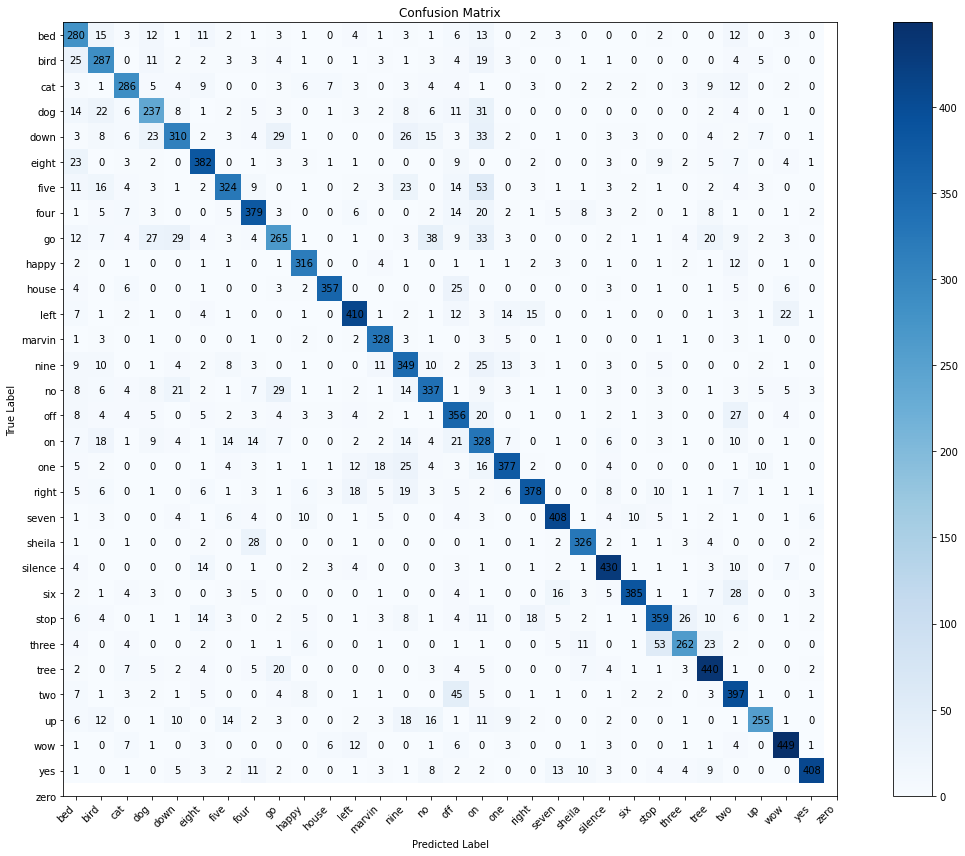

In [23]:
cm = results['confusion_matrix']
labels = list(train_loader.class_to_idx.keys())

fig, ax = plt.subplots(figsize=(20, 12))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=cm.max())

ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel='Predicted Label',
    ylabel='True Label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:d}", ha='center', va='center')

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()


In [4]:
## Training and testing for different data (MFCC)
model = SimpleCNN(
    in_channels=1,
    num_classes=31,
    lr = 0.0007660411998261092,
    dropout = 0.22102058843729233,
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [7]:
# prepare Data Loader files
train_dir = DATA_PATH / Path("MFCC_transformed", "training")
val_dir = DATA_PATH / Path("MFCC_transformed", "validation")
test_dir = DATA_PATH / Path("MFCC_transformed", "testing")

batch_size = 4

train_loader = DataLoader(
    data_dir=train_dir,
    data_type="mfcc",
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type="mfcc",
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type="mfcc",
    batch_size=batch_size,
    shuffle=True
)

In [8]:
# training loop
model.train_architecture(train_loader = train_loader, epochs = 10, val_loader=val_loader)

Epoch 1/10 - train loss: 2.4023 - train acc: 0.2832


Evaluating CNN: 100%|██████████| 3443/3443 [03:54<00:00, 14.67it/s]


Epoch 1/10 - val loss: 1.7622 - val acc: 0.4760 - val prec: 0.4968 - val rec: 0.4749 - val f1: 0.4625
Epoch 2/10 - train loss: 1.2690 - train acc: 0.6226


Evaluating CNN: 100%|██████████| 3443/3443 [00:21<00:00, 158.08it/s]


Epoch 2/10 - val loss: 1.0765 - val acc: 0.6730 - val prec: 0.6965 - val rec: 0.6690 - val f1: 0.6713
Epoch 3/10 - train loss: 0.8903 - train acc: 0.7343


Evaluating CNN: 100%|██████████| 3443/3443 [00:13<00:00, 255.03it/s]


Epoch 3/10 - val loss: 0.8584 - val acc: 0.7425 - val prec: 0.7636 - val rec: 0.7440 - val f1: 0.7474
Epoch 4/10 - train loss: 0.7191 - train acc: 0.7847


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 244.06it/s]


Epoch 4/10 - val loss: 0.8504 - val acc: 0.7457 - val prec: 0.7764 - val rec: 0.7451 - val f1: 0.7464
Epoch 5/10 - train loss: 0.6213 - train acc: 0.8144


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 152.93it/s]


Epoch 5/10 - val loss: 0.7486 - val acc: 0.7847 - val prec: 0.8026 - val rec: 0.7850 - val f1: 0.7869
Epoch 6/10 - train loss: 0.5554 - train acc: 0.8346


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 154.13it/s]


Epoch 6/10 - val loss: 0.7246 - val acc: 0.7830 - val prec: 0.7995 - val rec: 0.7821 - val f1: 0.7865
Epoch 7/10 - train loss: 0.5086 - train acc: 0.8460


Evaluating CNN: 100%|██████████| 3443/3443 [00:22<00:00, 154.62it/s]


Epoch 7/10 - val loss: 0.6654 - val acc: 0.8032 - val prec: 0.8203 - val rec: 0.8052 - val f1: 0.8087
Epoch 8/10 - train loss: 0.4717 - train acc: 0.8570


Evaluating CNN: 100%|██████████| 3443/3443 [00:12<00:00, 267.56it/s]


Epoch 8/10 - val loss: 0.6515 - val acc: 0.8127 - val prec: 0.8277 - val rec: 0.8115 - val f1: 0.8147
Epoch 9/10 - train loss: 0.4416 - train acc: 0.8665


Evaluating CNN: 100%|██████████| 3443/3443 [00:14<00:00, 239.36it/s]


Epoch 9/10 - val loss: 0.6550 - val acc: 0.8117 - val prec: 0.8280 - val rec: 0.8136 - val f1: 0.8170
Epoch 10/10 - train loss: 0.4210 - train acc: 0.8723


Evaluating CNN: 100%|██████████| 3443/3443 [00:12<00:00, 266.07it/s]


Epoch 10/10 - val loss: 0.6388 - val acc: 0.8191 - val prec: 0.8337 - val rec: 0.8199 - val f1: 0.8225


In [9]:
results = model.evaluate(test_loader)
print("Validation Summary:")
for k, v in results['summary'].items():
    print(f"  {k}: {v:.4f}")

Evaluating CNN: 100%|██████████| 3367/3367 [03:36<00:00, 15.55it/s]


Validation Summary:
  loss: 0.5919
  accuracy: 0.8354
  precision: 0.8477
  recall: 0.8349
  f1: 0.8376


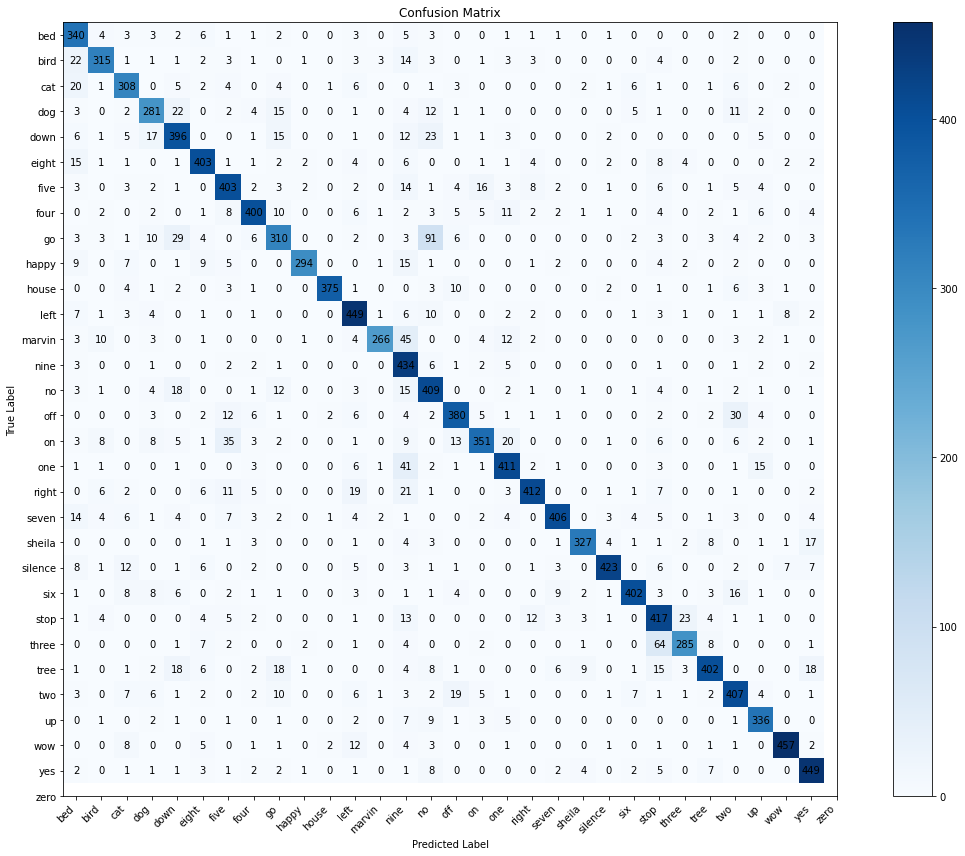

In [10]:
cm = results['confusion_matrix']
labels = list(train_loader.class_to_idx.keys())

fig, ax = plt.subplots(figsize=(20, 12))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=cm.max())

ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel='Predicted Label',
    ylabel='True Label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:d}", ha='center', va='center')

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()
